Run following code if specified libraries were not installed

In [ ]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install googlemaps
!{sys.executable} -m pip install googleplaces
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install shapely
!{sys.executable} -m pip install geopy

### Libraries
Libraries that I imported to generate the function:
1. pandas and numpy for basic computation
2. googlemaps is the official google maps API
3. googleplaces is a wrapper for googlemaps that lets us use the keyword search functionality: https://github.com/slimkrazy/python-google-places
4. geopandas used to create the geopandas data frames
5. Point function imported from shapely as it is needed as an object to plot
6. geopy has a distance.distance function which is used to calculate the distance between two points given their longitiude and latitiude

In [149]:
% matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Geospatial related libraries
import googlemaps
from googleplaces import GooglePlaces, types, lang
import geopandas as gpd
from shapely.geometry import Point
import geopy

API key that has google places and google geolocation permissions turned on

In [ ]:
API_KEY = input()
google_places = GooglePlaces(API_KEY)
gmaps = googlemaps.Client(key = API_KEY)

nearby_places is function created to generate geopandas data frames based off given address, type of place keyword, and radial distance

In [231]:
def nearby_places(address, place_type, r = 3200, latlng_dict = False):
    """
    This function was created to generate a geopandas dataframe when given a starting point address, type of place keyword,
    and search radius (in meters). 
    
    Address: String input with address of starting point
    Place_type: String input that describes type of place you are trying to find around the starting point. (Ex. "Starbucks", "Apple Store")
    r: Numeric input which acts as search radius around the starting point. Radius is in meters.
    latlng_dict: Dict input of latitutde, longitude coordinates if coordinates are known
    
    Geopandas dataframe will have columns of:
    Area - Identified Place
    Distance(mi) - Distance between locations in miles
    Index - Additional index column
    Latitude - Latitude coordinate of identified place
    Longitude - Longtitude coordinate of identified place
    Coordinates - Latitude and Longitude in Point class, used for plotting in geopandas 
    Query - Address string that was used in function call, can be used as grouping key
    
    """
    
    if type(latlng_dict) == dict:
        # google places query search 
        query_res = google_places.nearby_search(keyword = place_type, radius = r, lat_lng = latlng_dict)
        # google maps search for address
        geocode_result = gmaps.reverse_geocode((latlng_dict['lat'], latlng_dict['lng']))[0]
        np_query = place_type
    
    else:
        # google places query search
        query_res = google_places.nearby_search(location = address, keyword = place_type, radius = r)
        # google maps search for address
        geocode_result = gmaps.geocode(address)[0]
        np_query = address
        
    # Reference latitude and longitude to calculate distance
    gr_geometry = geocode_result['geometry']
    gr_location = gr_geometry['location']
    gr_lat = gr_location['lat']
    gr_lng = gr_location['lng']
    
    np_places = []
    np_index = []
    np_lat = []
    np_lng = []
    np_distance = []
    
    for i, pl in enumerate(query_res.places):
        
        pl_lat = pl.geo_location['lat']
        pl_lng = pl.geo_location['lng']
        
        np_places.append(pl.name)
        np_index.append(i)
        np_lat.append(float(pl_lat))
        np_lng.append(float(pl_lng))
        # Package to calculate distance between two points based on longitude and latitude
        np_distance.append(geopy.distance.distance((gr_lat, gr_lng), (pl_lat, pl_lng)).miles)
        
    np_df = pd.DataFrame({'Area': np_places, 'Index': np_index, 'Latitude': np_lat, 'Longitude': np_lng, 'Distance (mi)': np_distance, 'Query': np_query})
    np_df['Coordinates'] = list(zip(np_df['Longitude'], np_df['Latitude']))
    np_df['Coordinates'] = np_df['Coordinates'].apply(Point)
    np_df = gpd.GeoDataFrame(np_df).set_geometry('Coordinates')
    
    return np_df

In [232]:
def nearby_subway_stations(subway_list, keyword, subway_r, keyword_r):
    """
    This function is used to generate a GeoDataFrame when given a list of subwway stations and corresponding businesses.
    
    subway_list: List of subways where each entry is [name, value]
    keyword: Str type, keyword used to search for place around subway station (i.e. "Starbucks", "Apple Store")
    subway_r: Numeric type, used for radial distance search for subway station
    keyword_r: Numeric type, used for radial distance search of keyword businesses around subway station
    """
    
    # Base GeoDataFrame
    nss_gdf = gpd.GeoDataFrame()
    
    # Looping over each station in the subway list
    for station in subway_list:
        
        station_name = station[0]
        # Query call to search for longitude and latitude of actual station location using nearby_places function
        station_gdf = nearby_places(station_name + ' New York, NY', station_name + ' station', subway_r).head(1)
        station_lat = station_gdf['Latitude'].iloc[0]
        station_lng = station_gdf['Longitude'].iloc[0]
        station_latlng_dict = {'lat': station_lat, 'lng': station_lng}
        # Append station entry to base dataframe
        nss_gdf = nss_gdf.append(station_gdf)
        
        # nearby_places function call to find each of the keyword places around the given subway station
        pt_gdf = nearby_places(address = None, place_type = keyword, latlng_dict = station_latlng_dict, r = keyword_r)
        nss_gdf = nss_gdf.append(pt_gdf)
    
    nss_gdf = nss_gdf.reset_index()
    nss_gdf = nss_gdf.drop(axis = 1, labels = ['index'])
    
    return nss_gdf   

In [249]:
def stations_plot(df, filename, img_size = (20,10), zoom = False, msize = 50):
    """
    This function is used to plot the GeoDataFrame created from nearby_subway_stations() and will plot that on top
    of a given .geojson file that is located in the directory.
    
    df: GeoDataFrame created from nearby_subway_stations()
    filename: Str input, name of the .geojson file used for backgorund
    img_size: Tuple input, size of the generated figure
    zoom: Boolean input. If False will generate overall map, if True will zoom in to area of plotted points
    msize: Numeric input, marker size of the points on the station plot
    
    """
    fig, ax1 = plt.subplots(1, 1, figsize = img_size)
    df = df.set_geometry('Coordinates')
    background = gpd.read_file(filename)
    base = background.plot(ax = ax1, color='white', edgecolor='black')
    fig = df.plot(ax= base, markersize = msize, legend = True, column = 'Query')
    
    if zoom == True:
        minx, miny, maxx, maxy = test_gdf.total_bounds
        buffer = 0.01
        ax1.set_xlim(minx - buffer, maxx + buffer);
        ax1.set_ylim(miny - buffer, maxy + buffer);
    
    return fig

Example Call

In [193]:
subway_list = [['JEFFERSON ST', 8948.403846153846],
 ['14 ST-UNION SQ', 5806.954545454545],
 ['JOURNAL SQUARE', 3806.1666666666665],
 ['W 4 ST-WASH SQ', 2929.653846153846],
 ['7 AV', 2355.5625],
 ['34 ST-HERALD SQ', 2351.6346153846152],
 ['72 ST', 2345.4375],
 ['FLUSHING-MAIN', 2254.923076923077],
 ["BROADWAY-LAFAYETTE", 2012.2045454545455],
 ['KEW GARDENS', 1969.3958333333333]]

In [ ]:
test_gdf = nearby_subway_stations(subway_list, 'Starbucks', 6400, 300)
test_gdf

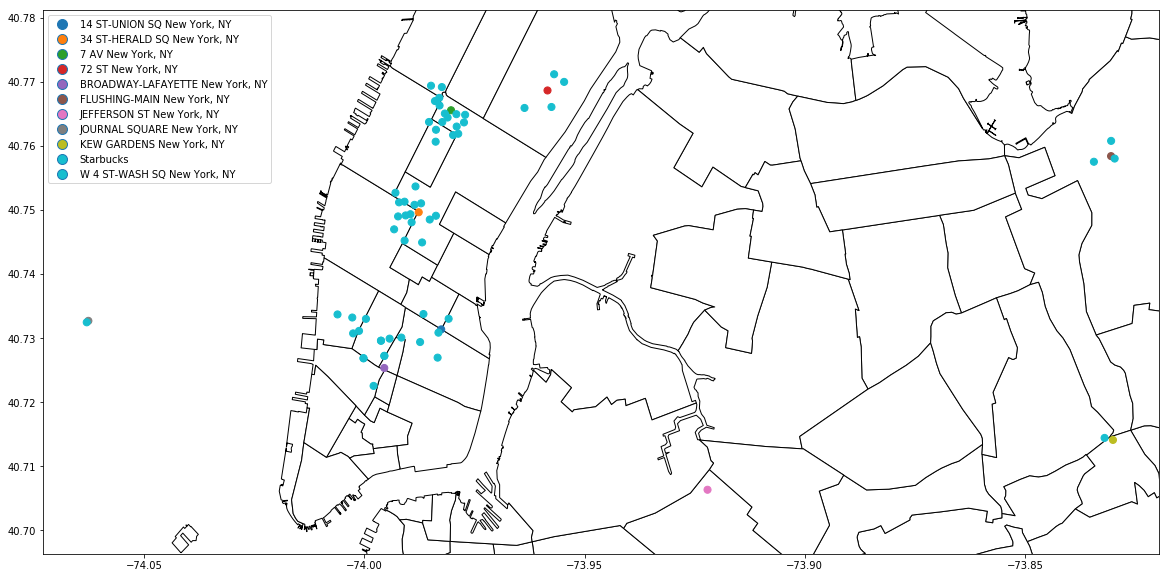

In [250]:
file = "d085e2f8d0b54d4590b1e7d1f35594c1pediacitiesnycneighborhoods.geojson"
fig1 = stations_plot(test_gdf, file, zoom = True)